<font size="20">Discount Prediction</font>

The objective of this "Discount Prediction" Competition was to build a machine learning model to Predict Medical Wholesales Discount to their customers. In this notebook, we will walk through a complete machine learning solution, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions. We would like to thank everyone for this hackathon.<br><br>
This notebook is majorly divided into three two parts.They are:
<ol>
<li>Exploratory Data Analysis and Preprocessing</li>
<li>Modeling</li><ul>
<li><b>LightGBM<b></li>
<li>XGBOOST</li>
<li>Random Forest</li>

<h1>Importing the Libraries</h1>

![](http://)We are gonna start of by importing the generic packages that everyone uses in their kernels.

In [1]:
import pandas as pd #Data Analysis
import numpy as np #Linear Algebra
import seaborn as sns #Data Visualization
import matplotlib.pyplot as plt #Data Visualization\
%matplotlib inline

These are import statements for plotply which is also a visualization library.

In [2]:
import json
import string
from pandas.io.json import json_normalize
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
import os
print(os.listdir("../input"))

['discount-prediction', 'removed']


<h1>Importing the datasets</h1>

In [4]:
#This is the Product_sales_train_and_test dataset but without the "[]" in the Customer Basket.
df=pd.read_csv("../input/removed//data.csv")

In [5]:
train=pd.read_csv("../input/discount-prediction/Train.csv")

In [6]:
test=pd.read_csv("../input/discount-prediction/test.csv")

In [7]:
product=pd.read_csv("../input/discount-prediction/product_details.csv",encoding="mac-roman")

In [8]:
#Removing the front and trailing spaces
df['Customer_Basket']=df['Customer_Basket'].str.lstrip()
df['Customer_Basket']=df['Customer_Basket'].str.rstrip()

In [9]:
#The count of the number of Product Id's in the Customer Basket
df['Length']=df['Customer_Basket'].str.split(' ').apply(len)

<h1>Exploratory Data Analysis with Preprocessing</h1>

In [10]:
df.head()

,BillNo,Customer_Basket,Length
0,A10455,1511 1046 1084 1730 1806 1316 1186 1418 1088 1...,61
1,A11277,1188 1226 1284 1406 1025 1769,6
2,A10842,1575 1064 1444 1314 1454 1247 1506 1354 1541 1...,40
3,A1572,1131 1101 1676 1206 1300 1384 1439 1667 1567 1...,29
4,A10924,1592 1320 1536 1775 1715 1447 1585 1322 1687 1...,46


In [11]:
train.head()

,BillNo,Date,Customer,Discount 5%,Discount 12%,Discount 18%,Discount 28%
0,ZA8180,01-04-2017,"TIRUVALLA MEDICAL MISSION, THIRUVALLA",NaN,NaN,NaN,1.0
1,ZA8169,01-04-2017,"BELIEVERS CHURCH, MEDICAL COLLEGE HOSPITAL",NaN,NaN,1.0,NaN
2,ZA8177,01-04-2017,"KADAVIL MEDICALS, MANNAR",NaN,NaN,NaN,1.0
3,ZA8172,01-04-2017,"S.N.MEDICALS, KADAPRA",NaN,NaN,NaN,1.0
4,ZA8173,01-04-2017,"BHARATH MEDICALS, KIZHAKENMUTTOOR",NaN,NaN,NaN,1.0


In [12]:
#We can see a lot of null values in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14021 entries, 0 to 14020
Data columns (total 7 columns):
BillNo          12200 non-null object
Date            12200 non-null object
Customer        12200 non-null object
Discount 5%     295 non-null float64
Discount 12%    9456 non-null float64
Discount 18%    615 non-null float64
Discount 28%    1909 non-null float64
dtypes: float64(4), object(3)
memory usage: 766.9+ KB


In [13]:
#Let us see number of null values there are
train.isnull().sum()

BillNo           1821
Date             1821
Customer         1821
Discount 5%     13726
Discount 12%     4565
Discount 18%    13406
Discount 28%    12112
dtype: int64

In [14]:
test.isnull().sum()

BillNo      0
Date        0
Customer    0
dtype: int64

No Null Values in the test dataset.

In [15]:
train[train['BillNo'].isna()].head(10)

,BillNo,Date,Customer,Discount 5%,Discount 12%,Discount 18%,Discount 28%
9648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9651,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9657,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From this we can tell that there are null values for the entire row present in the train dataset. The below code is to drop the entire row only when the entire row are "NaN" or null values.

In [16]:
train.dropna(axis=0,how='all',inplace=True)

In [17]:
train.isnull().sum()

BillNo              0
Date                0
Customer            0
Discount 5%     11905
Discount 12%     2744
Discount 18%    11585
Discount 28%    10291
dtype: int64

Now we can see that the majority of the null values are present in the Target variables. But we can impute these values with 0.

In [18]:
train.fillna(float(0.0),inplace=True)

In [19]:
train.isnull().sum()

BillNo          0
Date            0
Customer        0
Discount 5%     0
Discount 12%    0
Discount 18%    0
Discount 28%    0
dtype: int64

Finally we have no more null values.<br>

In [20]:
train['Customer'].value_counts().head()

BELIEVERS CHURCH, MEDICAL COLLEGE HOSPITAL                 445
TIRUVALLA MEDICAL MISSION, THIRUVALLA                      333
MUTHOOT MEDICAL CENTRE, KOZHENCHERRY                       293
AMIL MEDICALS, THIRUVALLA                                  232
MGM MUTHOOT MEDICAL CENTER PRIVATE LTD., PATHENAMTHITTA    189
Name: Customer, dtype: int64

In [21]:
len(set(test['Customer']).difference(set(train['Customer'])))

7

In [22]:
train['Discount 5%'].value_counts()

0.0    11930
1.0      270
Name: Discount 5%, dtype: int64

We can see that the classes are highly unbalanced. Let us visualise it for the other classes to understand this better.<br>
For the "Discount 5%" here the "1" represents the condition when discount is given and "0" is when the discount is not given.

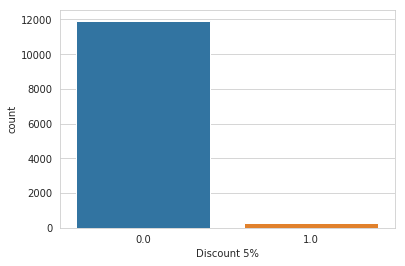

In [23]:
sns.set_style("whitegrid")
sns.countplot(x='Discount 5%',data=train)

It seems that there are very few 5% discounts. Now let us view it for the 12% Discount.

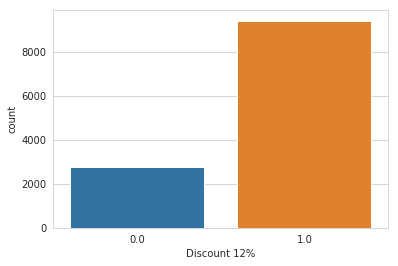

In [24]:
sns.set_style("whitegrid")
sns.countplot(x='Discount 12%',data=train)

From this we can tell that the majority of the Discounts were 12%. Let us look at the 18% Discount.

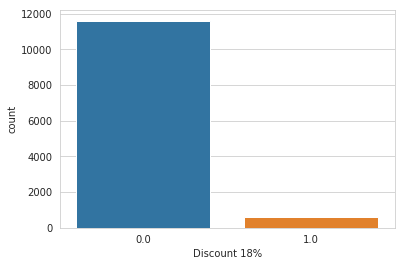

In [25]:
sns.set_style("whitegrid")
sns.countplot(x='Discount 18%',data=train)

Again we see the same pattern as in the 5% Discount but just a little more. Let us look at the final class i.e, 28% Discount.

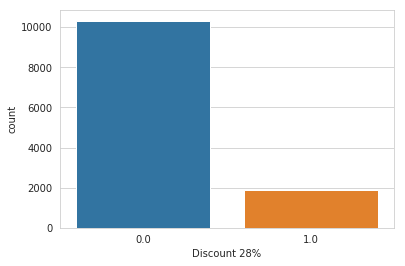

In [26]:
sns.set_style("whitegrid")
sns.countplot(x='Discount 28%',data=train)

We can see more discounts here and therefore is the second most occuring class after 12%. Since the class labels are so imbalanced we will be using SMOTE later on.<br><br>

We initially used the Customer variable but later on in our predictions we realised that it was actually degrading our model therefore we ended up not using it.

In [27]:
#lol=df2["Customer"].str.split(", ",n=1,expand=True)
#df2['CustomerName']=lol[0]
#df2["Location"]=lol[1]

In [28]:
#lol1=df3["Customer"].str.split(", ",n=1,expand=True)
#df3['CustomerName']=lol1[0]
#df3["Location"]=lol1[1]

In [29]:
#set(df3['Location']).difference(set(df2["Location"]))

In [30]:
#df3[df3["Location"]=='T.M.M. HOSPITAL, THIRUVALLA.']

In [31]:
#sns.countplot(x="discount",hue="Location",data=df3)

In [32]:
#df2["discount"].value_counts()

In [33]:
#len(set(trailtest['Customer']).difference(set(trailtrain['Customer'])))

Now we will create a function that will combine all the class labels into one Target variable.

In [34]:
discount=[]
for i, row in train.iterrows():
    if row["Discount 5%"]==1.0:
        discount.append(1)
    elif row["Discount 12%"]==1.0:
        discount.append(2)
    elif row["Discount 18%"]==1.0:
        discount.append(3)
    elif row["Discount 28%"]==1.0:
        discount.append(4)
    else:
        discount.append(5)        

In [35]:
train["discount"]=discount

Let us now plot the word count of "Customer" for each Discount Class.

In [36]:
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
train1_df = train[train["discount"]==1]
train2_df = train[train["discount"]==2]
train3_df = train[train["discount"]==3]
train4_df = train[train["discount"]==4]
train5_df = train[train["discount"]==5]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["Customer"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train2_df["Customer"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

freq_dict = defaultdict(int)
for sent in train3_df["Customer"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

freq_dict = defaultdict(int)
for sent in train4_df["Customer"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace3 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

freq_dict = defaultdict(int)
for sent in train5_df["Customer"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace4 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of Discount 5%", 
                                          "Frequent words of Discount 12%",
                                         "Frequent words of Discount 18%",
                                         "Frequent words of Discount 28%","Frequent words of No Discount"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace4, 3, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



From these plots we can see that not any customer was given an extra likelihood of discounts.

Let us drop the Discount columns now.

In [37]:
train.drop(['Discount 5%','Discount 12%','Discount 18%','Discount 28%'],axis=1,inplace=True)

Since to differentiate the Customer Basket is an NLP Problem we will be using CountVectoriser. It converts a collection of text documents to a matrix of token counts. 

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
cv1 = CountVectorizer(max_features=500)
y = cv1.fit_transform(df["Customer_Basket"]).toarray()

In [39]:
len(cv1.vocabulary_)

500

In [40]:
thirty= list(y)
thirty1=pd.DataFrame(thirty)

In [41]:
final=pd.concat([df,thirty1],axis=1)

In [42]:
finaltrain=pd.merge(train,final,on="BillNo",how="inner")
finaltest=pd.merge(test,final,on="BillNo",how="inner")

In [43]:
finaltrain.head()

,BillNo,Date,Customer,discount,Customer_Basket,Length,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,ZA8180,01-04-2017,"TIRUVALLA MEDICAL MISSION, THIRUVALLA",4,1655 1158 1257 1743 1499 1332 1470 1080 1492 1...,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ZA8169,01-04-2017,"BELIEVERS CHURCH, MEDICAL COLLEGE HOSPITAL",3,1307 1337 1112 1523 1394 1518 1289 1469 1612 1...,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [44]:
finaltest.head()

,BillNo,Date,Customer,Customer_Basket,Length,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,ZA8167,01-04-2017,"BELIEVERS CHURCH, MEDICAL COLLEGE HOSPITAL",1360 1272 1418 1225 1309 1722 1670 1158 1047 1...,75,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A8838,04-08-2018,"DR.T.S. KURUVILLA, S.H.MEDICAL CENTRE",1570 1495 1087 1108 1784 1365 1568 1573 1539 1...,61,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0

In [45]:
#df2=df2[df2["BillNo"]!=float(0.0)]

In [46]:
finaltrain.drop(["BillNo","Customer_Basket","Customer","Date"],axis=1,inplace=True)
finaltest.drop(["BillNo","Customer_Basket","Customer","Date"],axis=1,inplace=True)

In [47]:
X=finaltrain.drop("discount",axis=1)
y=finaltrain["discount"]

We will be using SMOTE here to balance the classes. It achieves this by oversampling. 

In [48]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [49]:
sm = SMOTE(random_state=2)

In [50]:
X_train_res, y_train_res = sm.fit_sample(X, y.ravel())

In [51]:
X_train=pd.DataFrame(X_train_res)

In [52]:
y_train=pd.DataFrame(y_train_res)

In [53]:
X_train["smote"]=y_train_res

In [54]:
X1=X_train.drop(["smote"],axis=1)
y1=X_train["smote"]

<font size="18">Modeling</font>

This is the modeling section of our notebook we will be using various machine learning models to perform our predictions. We have performed the submission file creation only for one of the models but did implement it for the rest of the models.

<h1>1. LightGBM</h1>

In [55]:
import lightgbm as lgb

In [56]:
model = lgb.LGBMClassifier( class_weight = 'balanced',
                               objective = 'multiclass', n_jobs = -1, n_estimators = 400)

In [57]:
model.fit(X1,y1)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=400, n_jobs=-1, num_leaves=31,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [58]:
pred_lg=model.predict(finaltest)

In [59]:
pred_lg

array([2, 2, 4, ..., 2, 2, 2])

<h1>2. XGBOOST</h1>

We commented the xgboost out becuase in the kernel it would show a long output on the kernel. The code definitely works for multiclass classification so you guys are free to run it.

In [60]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [61]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=300,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.6, seed=0, silent=0)                  

In [62]:
#xgb.fit(X1, y1)

In [63]:
#pred_xg=xgb.predict(finaltest)

<h1>3.Random Forest Classifier</h1>

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rfc=RandomForestClassifier(n_estimators=500)

In [66]:
rfc.fit(X1,y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
rfcpredict=rfc.predict(finaltest)

In [68]:
rfcpredict

array([2, 2, 2, ..., 2, 2, 2])

<h1>Cross Validation for Hyperparameter tuning</h1>

![](http://)We commented this out as it was taking too much time to commit and we didn't want our submission to be late.

In [69]:
#from sklearn.model_selection import StratifiedKFold
#kfold = 5
#skf = StratifiedKFold(n_splits=5)

In [70]:
#folds = 3
#param_comb = 5

#skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(rfc, param_distributions=params, n_iter=param_comb, scoring=rmsle, n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

In [71]:
#random_search.fit(X, y)

In [72]:
#print('\n All results:')
#print(random_search.cv_results_)
#print('\n Best estimator:')
#print(random_search.best_estimator_)
#print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
#print(random_search.best_score_ * 2 - 1)
#print('\n Best hyperparameters:')
#print(random_search.best_params_)

<h1>Result</h1>

At the end we were able to discern that LightGBM gave us the best results and that was what we submitted finally.
Once again we would like to thank everyone for making this hackathon really enjoyable and educational !!